In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,Input
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import os
from dotenv import load_dotenv
from pymongo import MongoClient


In [10]:
def process_and_forecast_one_week():
    # MongoDB setup
    load_dotenv()
    client = os.getenv("MONGO_URI")
    client = MongoClient(client)
    db = client["storage_simulation"]
    collection = db["usage_logs"]

    # Fetch data from MongoDB
    data = pd.DataFrame(list(collection.find()))
    # Preprocess data: Convert 'timestamp' to datetime and filter rows
    data.dropna(subset=['timestamp'], inplace=True)
    data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')
    data.dropna(subset=['timestamp'], inplace=True)
    data.set_index('timestamp', inplace=True)
    data.dropna(inplace=True)

    # Get list of unique directories
    directories = data['directory'].unique()

    # Dictionary to store results for each directory
    all_results = {}
    for directory in directories:
        print(f"\nProcessing directory: {directory}")

        # Filter data for current directory
        dir_data = data[data['directory'] == directory].copy()

        # -------- Weekly Forecast (using Daily data) --------
        df_daily = dir_data.resample('1D').mean(numeric_only=True)
        df_daily['directory'] = dir_data['directory'].resample('1D').first()
        df_daily.drop(columns=['directory'], inplace=True)
        df_daily.dropna(inplace=True)

        # Shift the data by 7 days to create weekly forecast target
        df_daily['storage_1week'] = df_daily['storage_gb'].shift(-7)
        df_daily.dropna(inplace=True)

        # Skip directories with insufficient data
        if len(df_daily) < 200:
            print(f"Skipping {directory} - not enough daily data for 1-week forecast.")
            continue

        # Train-test split
        split_idx = int(len(df_daily) * 0.8)
        train = df_daily.iloc[:split_idx]
        test = df_daily.iloc[split_idx:]

        # Naive forecast (just using the previous day's data for prediction)
        y_train = train['storage_1week']
        y_test = test['storage_1week']
        y_train_pred = train['storage_gb']
        y_test_pred = test['storage_gb']

        # Evaluate performance with RMSE and accuracy
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        train_mae = mean_absolute_error(y_train, y_train_pred)
        train_acc = 100 - (train_mae / y_train.mean() * 100)

        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
        test_mae = mean_absolute_error(y_test, y_test_pred)
        test_acc = 100 - (test_mae / y_test.mean() * 100)

        print(f"1-Week Ahead Forecast: Test Accuracy = {test_acc:.2f}%")

        # Plot
        fig, ax = plt.subplots(figsize=(10, 4))
        ax.plot(y_test.index, y_test, label='Actual', linewidth=2)
        ax.plot(y_test.index, y_test_pred, label='Naive Forecast', linestyle='--')
        ax.set_title(f'{directory} - Naive Forecast vs Actual (1-Week Ahead)')
        ax.set_xlabel('Date')
        ax.set_ylabel('Storage (GB)')
        ax.legend()
        ax.grid(True)
        plt.subplots_adjust(bottom=0.25)
        metrics_text = f"Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f} | Train Accuracy: {train_acc:.2f}% | Test Accuracy: {test_acc:.2f}%"
        plt.figtext(0.5, 0.01, metrics_text, wrap=True, ha='center', fontsize=10)
        plt.tight_layout()
        plt.show()


Processing directory: /scratch
1-Week Ahead Forecast: Test Accuracy = 93.29%


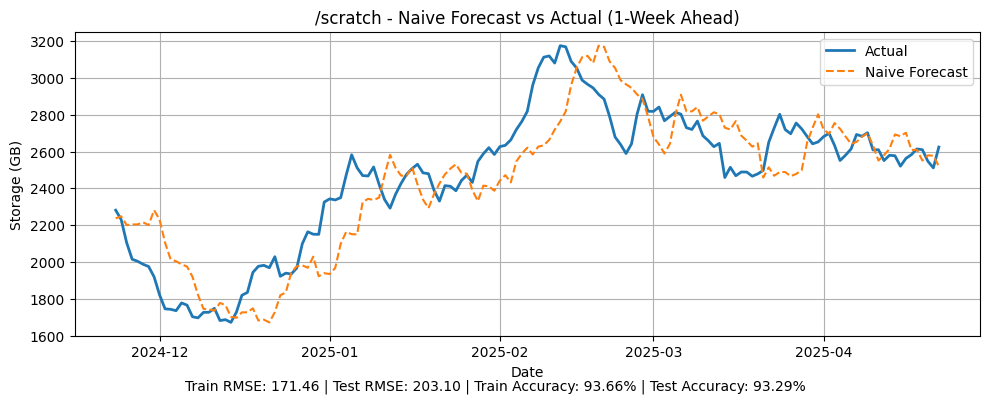


Processing directory: /projects
1-Week Ahead Forecast: Test Accuracy = 95.58%


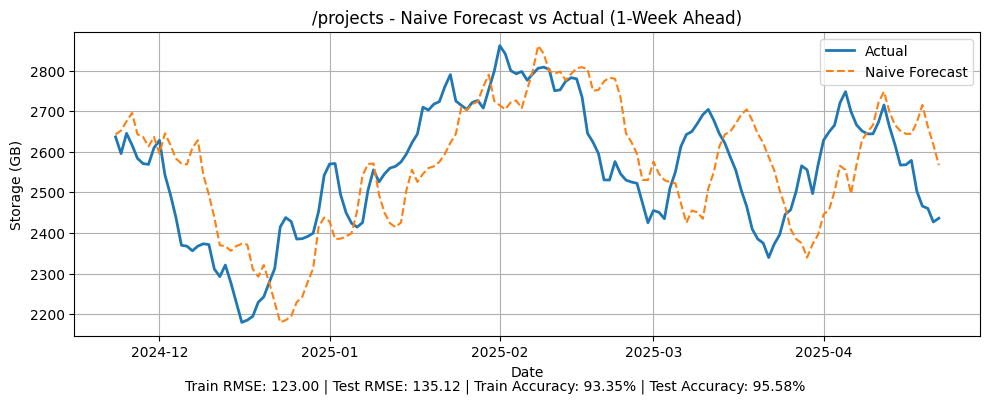


Processing directory: /customer
1-Week Ahead Forecast: Test Accuracy = 90.62%


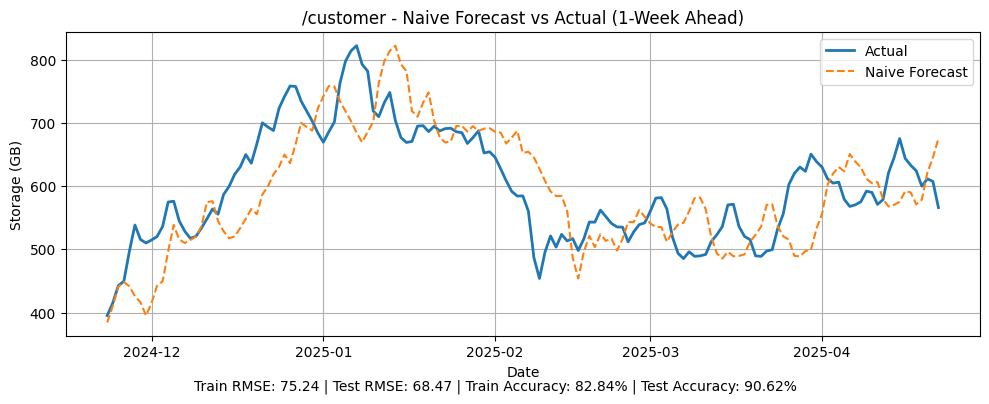


Processing directory: /info
1-Week Ahead Forecast: Test Accuracy = 94.55%


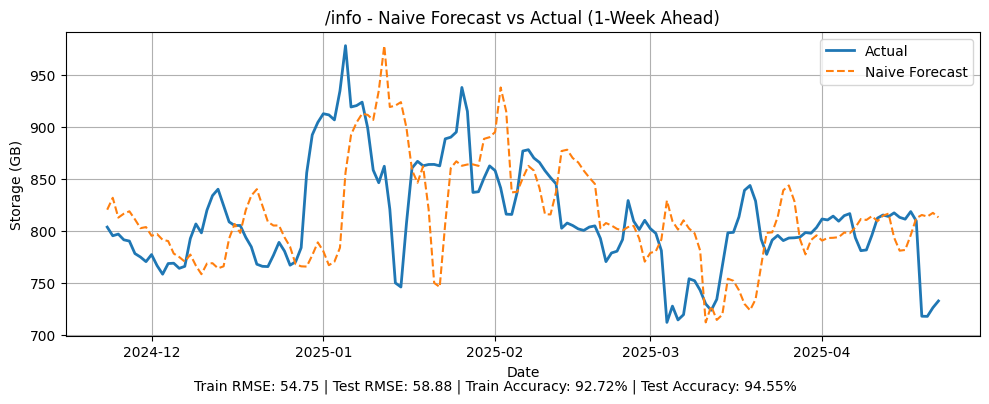

In [11]:
process_and_forecast_one_week()